# VERSION 1.0

#### I'm going to make a fake news predictor, and you are going to join me on my journey trying to solve one of humanities most difficult challenges. 
#### So, fake news has been around since before 'news' became a thing. But I want to tackle this issue, and try to contribute to saving democracy while preserving our rights to freedom of speech!

Now let's load the packages that we're going to need throughout our project.

In [43]:
# Data manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Modelling & Prediction 
import nltk as nltk
import re
from datetime import datetime
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from collections import Counter

sns.set(color_codes = True)
%matplotlib inline

#### Explore fake news dataset

We will first load the fake news dataset then run info function to have a look at the dataset and its content. You can see that there's 23481 rows and 5 columns in total. All columns has 'object' as type

In [44]:
fakeNewsData = pd.read_csv('data/Fake.csv', parse_dates=['date'])
fakeNewsData['label'] =  'fake'
fakeNewsData.info()
fakeNewsData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  object
dtypes: object(5)
memory usage: 917.4+ KB


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


#### Convert date column to datetime type

Hhhmmm, the date column looks kind of funny. Let's have a closer look at it. Let's list all of the unique values in the date column. Do you see what I see? No? have a closer look, there's a link in the date column! Wow, that's crazy.

In [45]:
fakeNewsData['date'].unique().tolist()

['December 31, 2017',
 'December 30, 2017',
 'December 29, 2017',
 'December 25, 2017',
 'December 23, 2017',
 'December 22, 2017',
 'December 21, 2017',
 'December 20, 2017',
 'December 19, 2017',
 'December 17, 2017',
 'December 16, 2017',
 'December 13, 2017',
 'December 12, 2017',
 'December 11, 2017',
 'December 10, 2017',
 'December 9, 2017',
 'December 7, 2017',
 'December 6, 2017',
 'December 5, 2017',
 'December 4, 2017',
 'December 3, 2017',
 'December 2, 2017',
 'December 1, 2017',
 'November 30, 2017',
 'November 29, 2017',
 'November 28, 2017',
 'November 27, 2017',
 'November 26, 2017',
 'November 25, 2017',
 'November 24, 2017',
 'November 23, 2017',
 'November 22, 2017',
 'November 21, 2017',
 'November 20, 2017',
 'November 19, 2017',
 'November 18, 2017',
 'November 17, 2017',
 'November 16, 2017',
 'November 15, 2017',
 'November 14, 2017',
 'November 13, 2017',
 'November 12, 2017',
 'November 11, 2017',
 'November 10, 2017',
 'November 9, 2017',
 'November 8, 2017'

You can see in the table and the list above that the date column has some issues compared to the true news date column. There's a link in the date column... huh? We don't want that. So, lets remove the links from the date column and convert the column to datetime.

In [46]:
fakeNewsData = fakeNewsData[fakeNewsData.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")] # get only string that contains the months
fakeNewsData['date'] = pd.to_datetime(fakeNewsData['date']) # convert column to datetime
fakeNewsData.info()
fakeNewsData.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23471 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    23471 non-null  object        
 1   text     23471 non-null  object        
 2   subject  23471 non-null  object        
 3   date     23471 non-null  datetime64[ns]
 4   label    23471 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ MB


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake


Now you can see that date columns is datetime type.

#### Explore the true dataset

Load the true news dataset then run info function to have a look at the dataset. 
You can see that there's 21417  rows and 5 columns in total. All columns has 'object' as type, except for the date column which is of datetime type

In [47]:
trueNewsData = pd.read_csv('data/True.csv', parse_dates=['date'])
trueNewsData['label'] = 'true'
trueNewsData.info()
trueNewsData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    21417 non-null  object        
 1   text     21417 non-null  object        
 2   subject  21417 non-null  object        
 3   date     21417 non-null  datetime64[ns]
 4   label    21417 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 836.7+ KB


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,true


#### Combine datasets

Now let's combined the datasets! And return the shape to ssee how many rows and columns are available.

In [48]:
# Concantenate the datasets, why? 
# Both datasets are very similar in terms of the columns. 
# Since their identical, we can't make a join on a column.
newsData = pd.concat([fakeNewsData, trueNewsData], ignore_index=True) # fakeNewsData.join(trueNewsData, how='outer', lsuffix="_left", rsuffix="_right")

# combine title and text to create a new column, news.
newsData['news'] = newsData['title'] + newsData['text']

# drop the title and text columns since they are not needed anymore.
newsData = newsData.drop(['title', 'text'], axis=1)

# # re-arrange the combined dataset columns
newsData = newsData.reindex(columns=['news', 'subject', 'date', 'label'])

Let's look at the shape of our combined data. You will notice that there's over 44k rows and 4 columns.

In [49]:
newsData.shape

(44888, 4)

#### Label distribution

Lets have a look at how the labels are distributed. You can see that fake news is more occurent than the true news. More fake articles than true/real articles. However, they are still fairly balanced I would say. Both are above the 20K. You agree? Of course you do.

C:\Users\Gebruiker\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

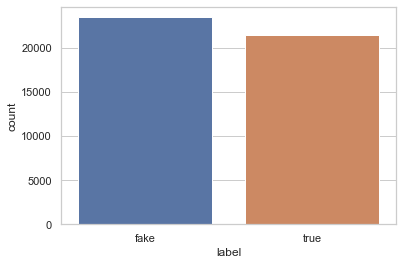

In [50]:
target_label = newsData['label']
sns.set_style('whitegrid')
sns.countplot(target_label)

#### Plot subjects by label

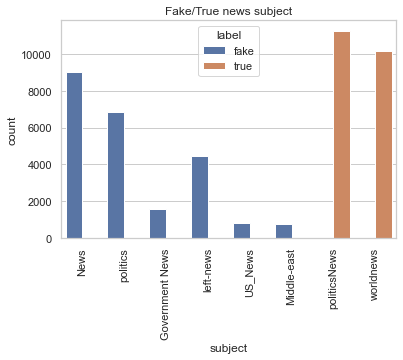

In [51]:
_ = sns.countplot(x ='subject', hue= 'label', data = newsData)
plt.xticks(rotation=90)
plt.title('Fake/True news subject')
plt.show()

Lets have a look at the subjects. You can see that there's some ambigous columns. For exmple, for the fake dataset "government news" and "politics" basically has the same meaning and what about "news" what type of news is it? It could be anything from my point of view.
Furthermore, "politics news" and "world news" has rows of more than 10k each. 

#### Cleaning news data in the news column

There's a lot of useless words in the dataset, and that's not good for our algorithm when it's time to predict. What should we do? Let's clean it up! We'll do that in a few steps. First we will remove all punctuation from the news column then we will remove the stop words. Stop words are words such as the, a, an, in, and more. So, this way only the important words will be used by our algorithm to predict.

In [52]:
stop_words = stopwords.words('english')

In [53]:
def clean_data(word):
#     word = str(word).lower() # set all to lowercase
    word = re.sub(r'[^\w\s]', '', word) # remove punctuation
    return word

In [54]:
# use lambda function here to apply the clean_data() to the news column
# use axis 0 to apply function to each column and axis 1 to apply function to each row.
newsData.news = newsData.news.apply(lambda x:clean_data(x))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-5d7167341493>", line 3, in <module>
    newsData.news = newsData.news.apply(lambda x:clean_data(x))
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\pandas\core\series.py", line 4200, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas\_libs\lib.pyx", line 2402, in pandas._libs.lib.map_infer
  File "<ipython-input-54-5d7167341493>", line 3, in <lambda>
    newsData.news = newsData.news.apply(lambda x:clean_data(x))
  File "<ipython-input-53-04b5a65cad63>", line 3, in clean_data
    word = re.sub(r'[^\w\s]', '', word) # remove punctuation
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\IPython\cor

TypeError: object of type 'NoneType' has no len()

After calling the clean_data(), let's have a look at the dataframe. Immediately, you can see the clear difference (btw the difference is in the news column). There's no commas, or dots, or brackets, none of that. ALL GONE!

In [ ]:
newsData.head()

In the next step we're going to remove stop words. To have a more clearer visual of what happened, let's return the length of characters in the first row.

#### Remove stop words

Above you can see the length is 4568. Now let's remove the stop words then have a look at the length again.

In [ ]:
len(newsData.news.values[0])

In [ ]:
newsData.news = newsData.news.apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

After removing the stop words, you can see the strong difference in the length of characters in the first row. Removing stop words makes it easier for our algorithm to predict

In [ ]:
len(newsData.news.values[0])

Now that our news data looks better and ready for prediction, let's plot a word cloud to have a visualization of the most frequent words in news that's labeled as fake news. 

But this one might be a bit more advance. You're probably wondering why, that's a good question. The words we are going to plot in the word cloud are the 50 most common words in the fake news. This is done by using collections Counter. This class is very useful to count the frequency of elements in an iterable. It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values. 

#### Word cloud

Lets use counter on news labeled as fake news to return the most common 100 words.

In [ ]:
text = Counter(" ".join(newsData[newsData['label'] == 'fake']['news']).split()).most_common(100)
wordcloud = WordCloud(width=1000, height=500, background_color = 'black', stopwords = stop_words).generate(str(text))

fig, ax = plt.subplots(figsize=(40,40))
plt.imshow( wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

You can see that the most frequent words are US, Trump, President, Clinton and more. So, as i said in the project proposal the prediction will be biased and will not perform well with other types of news because it's being trained and tested on world news, and american news (regarding the 2016 election). 
However, as our we modify our algorithm and tune it, we can have it predict all types of news. But for now, let's use this dataset just to see how well it predicts fake news.

In [ ]:
# from nltk.stem import WordNetLemmatizer 

# lemmatizer = WordNetLemmatizer()
# newsData.news = newsData.news.apply(lambda x: [word_tokenize(x)])
# newsData.news = newsData.news.apply(lambda b: ' '.join([lemmatizer.lemmatize(u) for u in b.split()]))


#### Split training and testing sets

Now that all the boring stuff is done, let's get to work. In the next part i will show you how we're going to split our dataset into train and test sets!
We're going to use 30% of our data for testing set with a random state of 42.

In [ ]:
y = newsData.label
X = newsData.news

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

After splitting the data, we can see that X has a shape of 31421 values and y with 13467 values.

In [ ]:
X_train.shape

In [ ]:
y_train.shape